In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import models

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Images are normalized to have pixel values from 0 to 1
## The size is [1,28,28]

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
len(mnist_trainset)

60000

In [3]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())
len(mnist_testset)

10000

In [4]:
batch_size = 64

In [5]:
mnist_trainset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [6]:
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size)

torch.Size([64, 1, 28, 28])


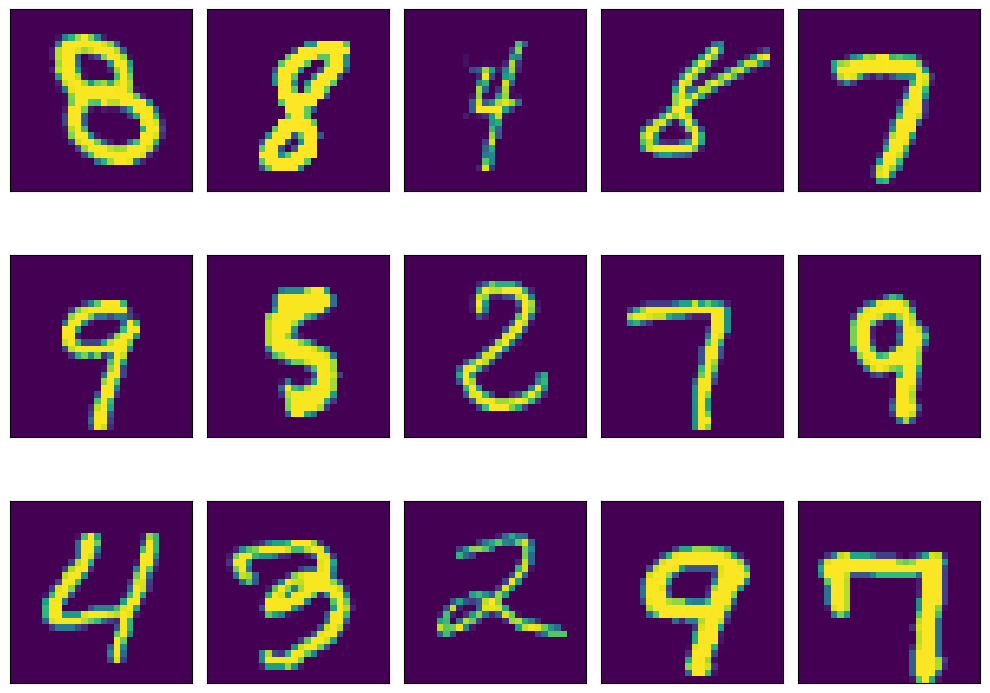

In [7]:
import matplotlib.pyplot as plt


for images, labels in train_loader:
    print(images.shape)
    break
    
plt.figure(figsize=(10,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.xticks([], [])
    plt.yticks([], [])
plt.tight_layout()

# I load resnet18 from torchvision and change first and last layer to fit the image size and number of classes

In [8]:
model = models.resnet18(pretrained=False)

def change_layers(model):
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(512, 10, bias=True)
    
change_layers(model)
model.to(device)
print('model defined')

model defined


In [9]:
num_epochs = 3
learning_rate = 0.01

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

In [10]:
# Train the model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()

    print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
        print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total)) 

Epoch [1/3], Loss: 0.0886
Accuracy of the network on the 10000 test images: 98.21 %
Epoch [2/3], Loss: 0.0037
Accuracy of the network on the 10000 test images: 98.84 %
Epoch [3/3], Loss: 0.0116
Accuracy of the network on the 10000 test images: 98.9 %


# Three epochs of the training gives very good performance and is enough for the purpose of embedding

In [11]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('resnet18MNIST.pt') # Save

In [12]:
torch.save(model, 'resnet18MNIST')